# Reddit AITA Dataset Analysis

Types of analysis done on both main and 2500 samples datasets
- ambiguity score
- comment AITA classification
- token counts for flanT5 and llama2 instructions

## Prepare environment

In [1]:
%pip install datasets transformers krippendorff seaborn huggingface_hub ipywidgets pandas numpy

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.1 -> 24.0
[notice] To update, run: C:\Users\mattb\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [9]:
!mkdir analysis_results\main_dataset\Decision_Ambiguity_Analysis
!mkdir analysis_results\main_dataset\Comment_Agreement_Analysis
!mkdir analysis_results\main_dataset\Token_Count_Analysis

!mkdir analysis_results\2500_samples_dataset\Decision_Ambiguity_Analysis
!mkdir analysis_results\2500_samples_dataset\Comment_Agreement_Analysis
!mkdir analysis_results\2500_samples_dataset\Token_Count_Analysis

## Loading of Datasets

In [3]:
from huggingface_hub import notebook_login

notebook_login()

In [4]:
from datasets import load_dataset
dataset = load_dataset('MattBoraske/reddit-AITA-submissions-and-comments')
samples_2500_dataset = load_dataset('MattBoraske/reddit-AITA-submissions-and-comments-top-2500')

Generating train split:   0%|          | 0/58438 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/14610 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/500 [00:00<?, ? examples/s]

## Flan-T5 and Llama-2 Token Count Analysis

In [5]:
from transformers import PreTrainedTokenizer, AutoTokenizer
from datasets import Dataset

def add_token_counts_to_dataset(dataset: Dataset, column: str, tokenizer: PreTrainedTokenizer, new_column_name: str) -> Dataset:
    """
    Adds a new column to a specified partition of a dataset with the number of tokens in each row of a specified column.

    Parameters:
      dataset (Dataset): A Hugging Face dataset object.
      column (str): The name of the column in the dataset partition to process.
      tokenizer: A Hugging Face transformers pretrained tokenizer
      new_column_name (str): The name of the new column to be added to the dataset.

    Returns:
      Dataset: The modified dataset with an additional column for token counts.
    """

    def count_tokens(row):
        row_tokens = tokenizer(row[column], padding=False, truncation=False, return_tensors="pt")
        tokens_count = len([tensor.item() for tensor in row_tokens['input_ids'][0]])
        return {new_column_name: tokens_count}
    
    return dataset.map(count_tokens)

In [6]:
flanT5_tokenizer = AutoTokenizer.from_pretrained("google/flan-t5-xl", trust_remote_code=True)
llama2_tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-2-7b-chat-hf", trust_remote_code=True)

dataset = add_token_counts_to_dataset(dataset, 'flanT5_instruction', flanT5_tokenizer, 'flanT5_instruction_token_count')
dataset = add_token_counts_to_dataset(dataset, 'llama2_instruction', llama2_tokenizer, 'llama2_instruction_token_count')

samples_2500_dataset = add_token_counts_to_dataset(samples_2500_dataset, 'flanT5_instruction', flanT5_tokenizer, 'flanT5_instruction_token_count')
samples_2500_dataset = add_token_counts_to_dataset(samples_2500_dataset, 'llama2_instruction', llama2_tokenizer, 'llama2_instruction_token_count')


Map:   0%|          | 0/58438 [00:00<?, ? examples/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (532 > 512). Running this sequence through the model will result in indexing errors


Map:   0%|          | 0/14610 [00:00<?, ? examples/s]

Map:   0%|          | 0/58438 [00:00<?, ? examples/s]

Map:   0%|          | 0/14610 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

In [7]:
def calculate_token_counts(dataset, split):
    token_counts = {
        'llama2_instruction_token_count': [],
        'flanT5_instruction_token_count': []
    }

    # Iterate over all examples in the split
    for example in dataset[split]:
        token_counts['llama2_instruction_token_count'].append(example['llama2_instruction_token_count'])
        token_counts['flanT5_instruction_token_count'].append(example['flanT5_instruction_token_count'])

    return token_counts

# Calculate token counts for both train and test splits
token_counts = {
    'train': calculate_token_counts(dataset, 'train'),
    'test': calculate_token_counts(dataset, 'test')
}

samples_2500_token_counts = {
    'train': calculate_token_counts(samples_2500_dataset, 'train'),
    'test': calculate_token_counts(samples_2500_dataset, 'test')
}

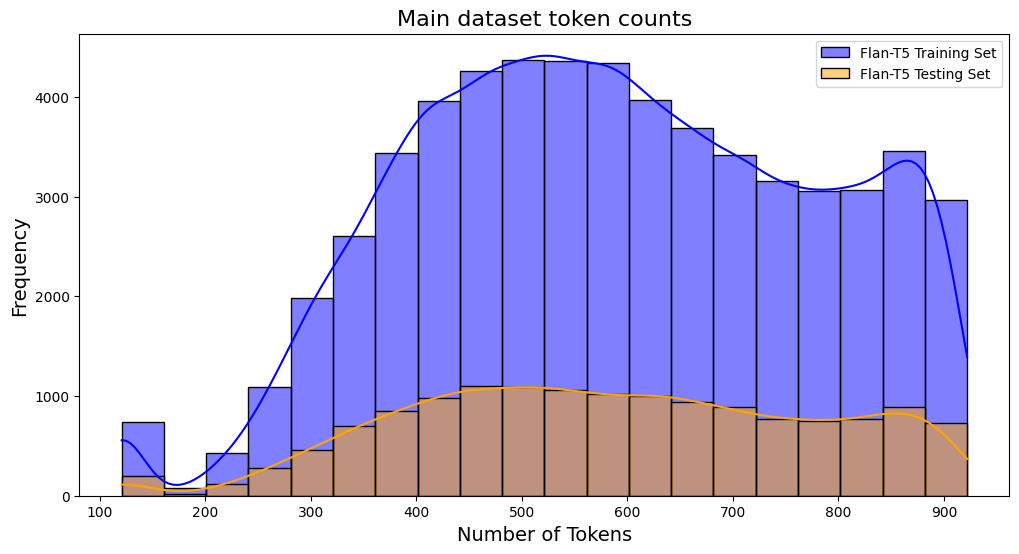

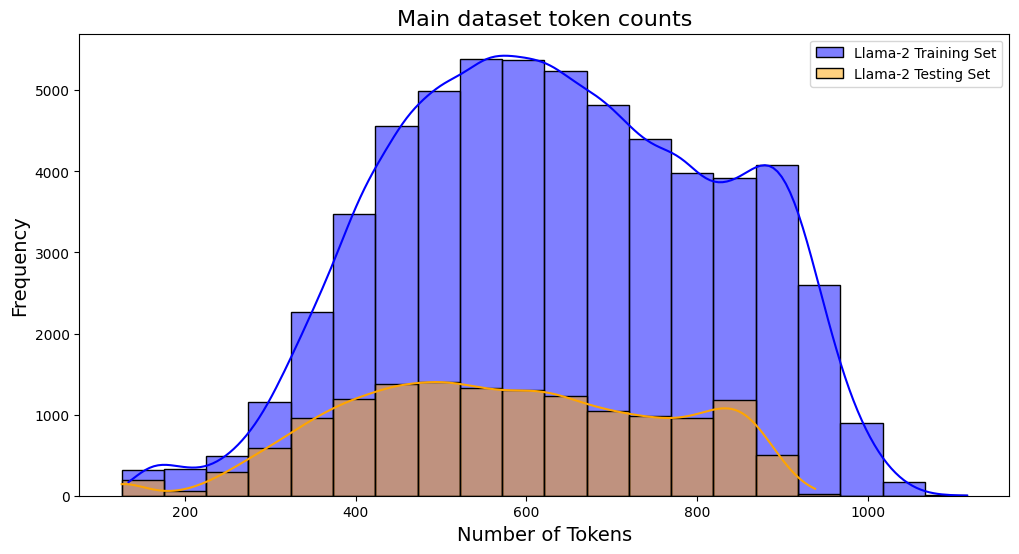

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Calculate the common bin edges for both train and test submissions
combined_data = np.concatenate([token_counts['train']['flanT5_instruction_token_count'], token_counts['test']['flanT5_instruction_token_count']])
bin_edges = np.histogram_bin_edges(combined_data, bins=20)

# Get histogram bin counts for train and test submissions
flant5_train_counts, _ = np.histogram(token_counts['train']['flanT5_instruction_token_count'], bins=bin_edges)
flant5_test_counts, _ = np.histogram(token_counts['test']['flanT5_instruction_token_count'], bins=bin_edges)

# Plot histograms
plt.figure(figsize=(12, 6))
sns.histplot(token_counts['train']['flanT5_instruction_token_count'], bins=bin_edges, kde=True, label='Flan-T5 Training Set', color='blue')
sns.histplot(token_counts['test']['flanT5_instruction_token_count'], bins=bin_edges, kde=True, label='Flan-T5 Testing Set', color='orange')
plt.title('Main dataset token counts', fontsize=16)
plt.xlabel('Number of Tokens', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.legend()
plt.savefig('analysis_results/main_dataset/Token_Count_Analysis/flanT5_token_counts.png')
plt.show()

# Log Histogram Bin Counts
bin_labels = [f"{bin_edges[i]:.2f} - {bin_edges[i+1]:.2f}" for i in range(len(bin_edges)-1)]
flant5_counts_df = pd.DataFrame({'Bin Ranges': bin_labels, 'Test': flant5_train_counts, 'Train': flant5_test_counts}, index=bin_labels)
flant5_counts_df.to_csv('analysis_results/main_dataset/Token_Count_Analysis/flanT5_token_bins.csv', index=False)


# Calculate the common bin edges for both train and test submissions
combined_data = np.concatenate([token_counts['train']['llama2_instruction_token_count'], token_counts['test']['llama2_instruction_token_count']])
bin_edges = np.histogram_bin_edges(combined_data, bins=20)

# Get histogram bin counts for train and test submissions
ambiguity_train_counts, _ = np.histogram(token_counts['train']['llama2_instruction_token_count'], bins=bin_edges)
ambiguity_test_counts, _ = np.histogram(token_counts['test']['llama2_instruction_token_count'], bins=bin_edges)

# Plot histograms
plt.figure(figsize=(12, 6))
sns.histplot(token_counts['train']['llama2_instruction_token_count'], bins=bin_edges, kde=True, label='Llama-2 Training Set', color='blue')
sns.histplot(token_counts['test']['llama2_instruction_token_count'], bins=bin_edges, kde=True, label='Llama-2 Testing Set', color='orange')
plt.title('Main dataset token counts', fontsize=16)
plt.xlabel('Number of Tokens', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.legend()
plt.savefig('analysis_results/main_dataset/Token_Count_Analysis/llama2_token_counts.png')
plt.show()

# Log Histogram Bin Counts
bin_labels = [f"{bin_edges[i]:.2f} - {bin_edges[i+1]:.2f}" for i in range(len(bin_edges)-1)]
llama2_counts_df = pd.DataFrame({'Bin Ranges': bin_labels, 'Test': ambiguity_train_counts, 'Train': ambiguity_test_counts}, index=bin_labels)
llama2_counts_df.to_csv('analysis_results/main_dataset/Token_Count_Analysis/llama2_token_bins.csv', index=False)

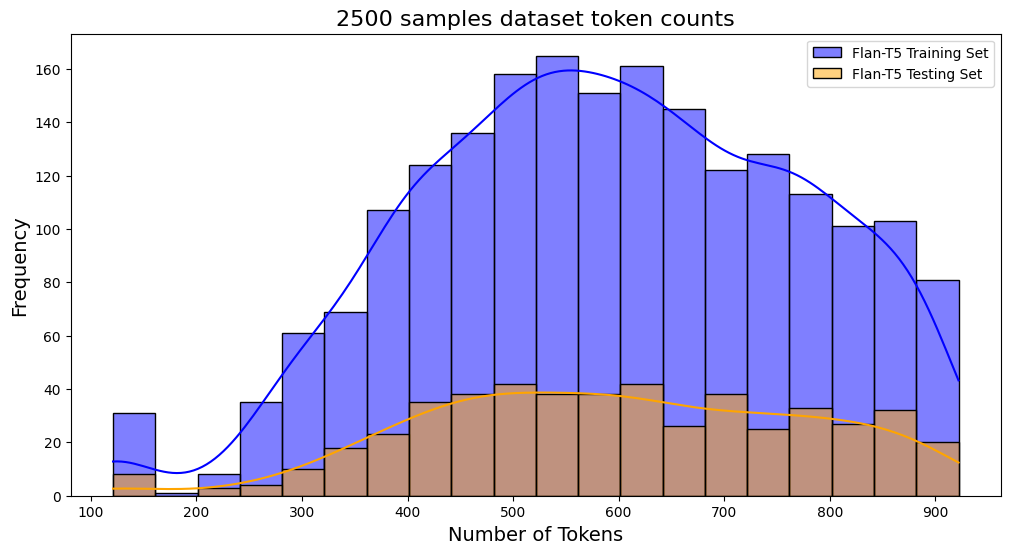

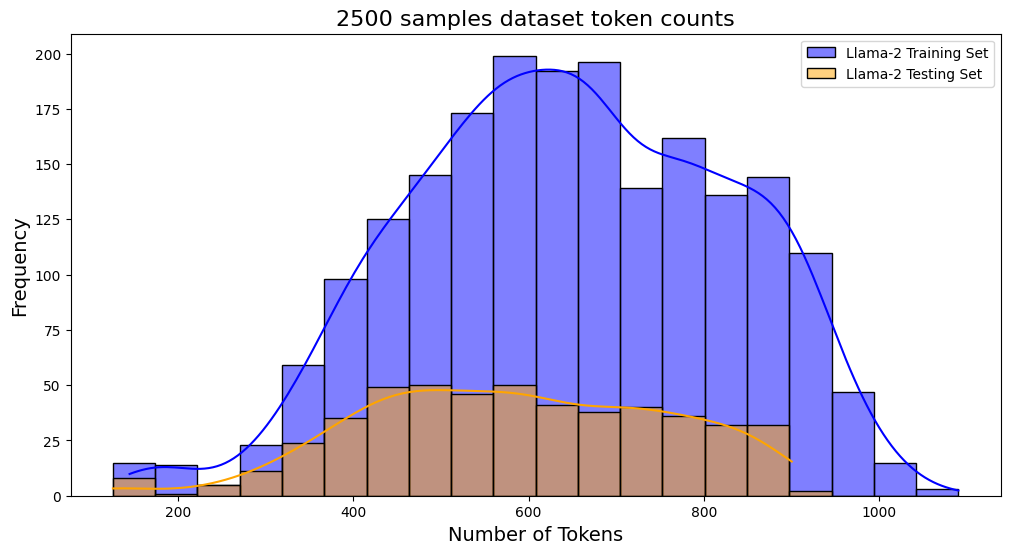

In [12]:
# Calculate the common bin edges for both train and test submissions
combined_data = np.concatenate([samples_2500_token_counts['train']['flanT5_instruction_token_count'], samples_2500_token_counts['test']['flanT5_instruction_token_count']])
bin_edges = np.histogram_bin_edges(combined_data, bins=20)

# Get histogram bin counts for train and test submissions
flant5_train_counts, _ = np.histogram(samples_2500_token_counts['train']['flanT5_instruction_token_count'], bins=bin_edges)
flant5_test_counts, _ = np.histogram(samples_2500_token_counts['test']['flanT5_instruction_token_count'], bins=bin_edges)

# Plot histograms
plt.figure(figsize=(12, 6))
sns.histplot(samples_2500_token_counts['train']['flanT5_instruction_token_count'], bins=bin_edges, kde=True, label='Flan-T5 Training Set', color='blue')
sns.histplot(samples_2500_token_counts['test']['flanT5_instruction_token_count'], bins=bin_edges, kde=True, label='Flan-T5 Testing Set', color='orange')
plt.title('2500 samples dataset token counts', fontsize=16)
plt.xlabel('Number of Tokens', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.legend()
plt.savefig('analysis_results/2500_samples_dataset/Token_Count_Analysis/flanT5_token_counts.png')
plt.show()

# Log Histogram Bin Counts
bin_labels = [f"{bin_edges[i]:.2f} - {bin_edges[i+1]:.2f}" for i in range(len(bin_edges)-1)]
flant5_counts_df = pd.DataFrame({'Bin Ranges': bin_labels, 'Test': flant5_train_counts, 'Train': flant5_test_counts}, index=bin_labels)
flant5_counts_df.to_csv('analysis_results/2500_samples_dataset/Token_Count_Analysis/flanT5_token_bins.csv', index=False)


# Calculate the common bin edges for both train and test submissions
combined_data = np.concatenate([samples_2500_token_counts['train']['llama2_instruction_token_count'], samples_2500_token_counts['test']['llama2_instruction_token_count']])
bin_edges = np.histogram_bin_edges(combined_data, bins=20)

# Get histogram bin counts for train and test submissions
ambiguity_train_counts, _ = np.histogram(samples_2500_token_counts['train']['llama2_instruction_token_count'], bins=bin_edges)
ambiguity_test_counts, _ = np.histogram(samples_2500_token_counts['test']['llama2_instruction_token_count'], bins=bin_edges)

# Plot histograms
plt.figure(figsize=(12, 6))
sns.histplot(samples_2500_token_counts['train']['llama2_instruction_token_count'], bins=bin_edges, kde=True, label='Llama-2 Training Set', color='blue')
sns.histplot(samples_2500_token_counts['test']['llama2_instruction_token_count'], bins=bin_edges, kde=True, label='Llama-2 Testing Set', color='orange')
plt.title('2500 samples dataset token counts', fontsize=16)
plt.xlabel('Number of Tokens', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.legend()
plt.savefig('analysis_results/2500_samples_dataset/Token_Count_Analysis/llama2_token_counts.png')
plt.show()

# Log Histogram Bin Counts
bin_labels = [f"{bin_edges[i]:.2f} - {bin_edges[i+1]:.2f}" for i in range(len(bin_edges)-1)]
llama2_counts_df = pd.DataFrame({'Bin Ranges': bin_labels, 'Test': ambiguity_train_counts, 'Train': ambiguity_test_counts}, index=bin_labels)
llama2_counts_df.to_csv('analysis_results/2500_samples_dataset/Token_Count_Analysis/llama2_token_bins.csv', index=False)

In [52]:
dataset["train"] = dataset["train"].remove_columns(["flanT5_instruction_token_count", "llama2_instruction_token_count"])
dataset["test"] = dataset["test"].remove_columns(["flanT5_instruction_token_count", "llama2_instruction_token_count"])

samples_2500_dataset["train"] = samples_2500_dataset["train"].remove_columns(["flanT5_instruction_token_count", "llama2_instruction_token_count"])
samples_2500_dataset["test"] = samples_2500_dataset["test"].remove_columns(["flanT5_instruction_token_count", "llama2_instruction_token_count"])

## Ambiguity Score Analysis

In [13]:
def get_ambiguity_scores(dataset, split):

    scores = []
    for example in dataset[split]:
        scores.append(example['ambiguity_score'])
    return scores

# Calculate token counts for both train and test splits
ambiguity_scores = {
    'train': get_ambiguity_scores(dataset, 'train'),
    'test': get_ambiguity_scores(dataset, 'test')
}

samples_2500_ambiguity_scores = {
    'train': get_ambiguity_scores(samples_2500_dataset, 'train'),
    'test': get_ambiguity_scores(samples_2500_dataset, 'test')
}


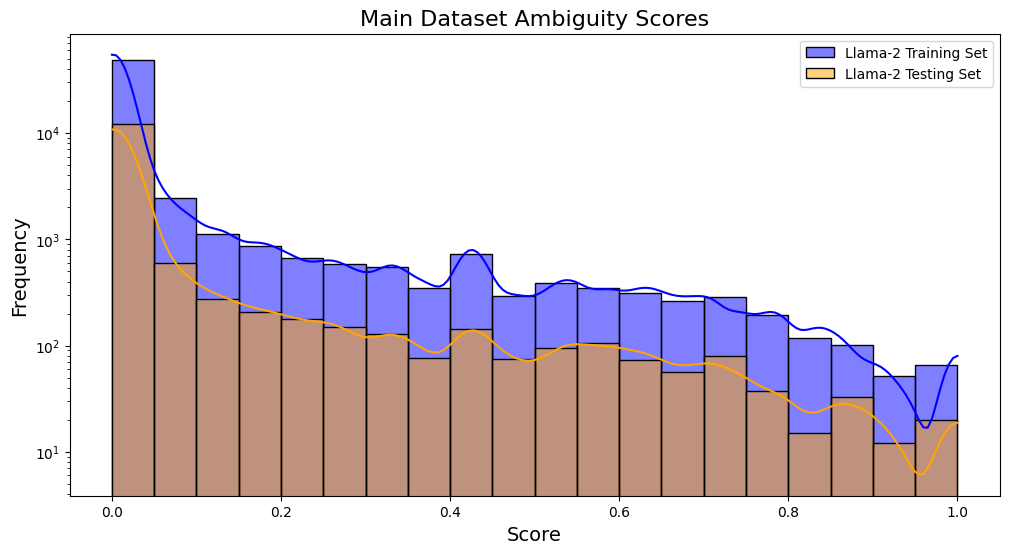

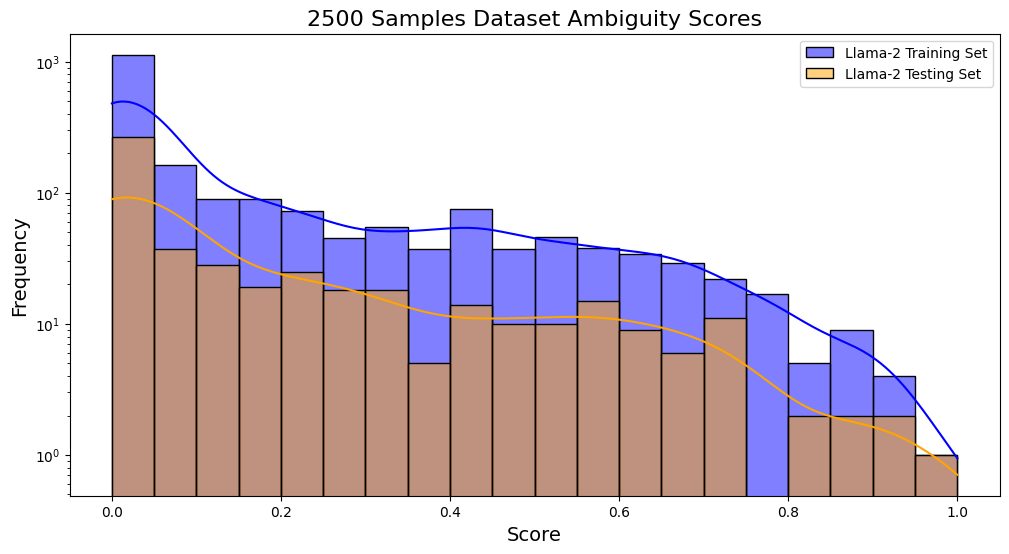

In [15]:
# Calculate the common bin edges for both train and test submissions
combined_data = np.concatenate([ambiguity_scores['train'], ambiguity_scores['test']])
bin_edges = np.histogram_bin_edges(combined_data, bins=20)

# Get histogram bin counts for train and test submissions
ambiguity_train_counts, _ = np.histogram(ambiguity_scores['train'], bins=bin_edges)
ambiguity_test_counts, _ = np.histogram(ambiguity_scores['test'], bins=bin_edges)

# Plot histograms
plt.figure(figsize=(12, 6))
sns.histplot(ambiguity_scores['train'], bins=bin_edges, kde=True, label='Llama-2 Training Set', color='blue')
sns.histplot(ambiguity_scores['test'], bins=bin_edges, kde=True, label='Llama-2 Testing Set', color='orange')
plt.title('Main Dataset Ambiguity Scores', fontsize=16)
plt.xlabel('Score', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.yscale('log')
plt.legend()
plt.savefig('analysis_results/main_dataset/Decision_Ambiguity_Analysis/ambiguity_scores.png')
plt.show()

# Log Histogram Bin Counts
bin_labels = [f"{bin_edges[i]:.2f} - {bin_edges[i+1]:.2f}" for i in range(len(bin_edges)-1)]
llama2_counts_df = pd.DataFrame({'Bin Ranges': bin_labels, 'Test': ambiguity_train_counts, 'Train': ambiguity_test_counts}, index=bin_labels)
llama2_counts_df.to_csv('analysis_results/main_dataset/Decision_Ambiguity_Analysis/ambiguity_scores_bins.csv', index=False)


# Calculate the common bin edges for both train and test submissions
combined_data = np.concatenate([samples_2500_ambiguity_scores['train'], samples_2500_ambiguity_scores['test']])
bin_edges = np.histogram_bin_edges(combined_data, bins=20)

# Get histogram bin counts for train and test submissions
ambiguity_train_counts, _ = np.histogram(samples_2500_ambiguity_scores['train'], bins=bin_edges)
ambiguity_test_counts, _ = np.histogram(samples_2500_ambiguity_scores['test'], bins=bin_edges)

# Plot histograms
plt.figure(figsize=(12, 6))
sns.histplot(samples_2500_ambiguity_scores['train'], bins=bin_edges, kde=True, label='Llama-2 Training Set', color='blue')
sns.histplot(samples_2500_ambiguity_scores['test'], bins=bin_edges, kde=True, label='Llama-2 Testing Set', color='orange')
plt.title('2500 Samples Dataset Ambiguity Scores', fontsize=16)
plt.xlabel('Score', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.yscale('log')
plt.legend()
plt.savefig('analysis_results/2500_samples_dataset/Decision_Ambiguity_Analysis/ambiguity_scores.png')
plt.show()

# Log Histogram Bin Counts
bin_labels = [f"{bin_edges[i]:.2f} - {bin_edges[i+1]:.2f}" for i in range(len(bin_edges)-1)]
llama2_counts_df = pd.DataFrame({'Bin Ranges': bin_labels, 'Test': ambiguity_train_counts, 'Train': ambiguity_test_counts}, index=bin_labels)
llama2_counts_df.to_csv('analysis_results/2500_samples_dataset/Decision_Ambiguity_Analysis/ambiguity_scores_bins.csv', index=False)

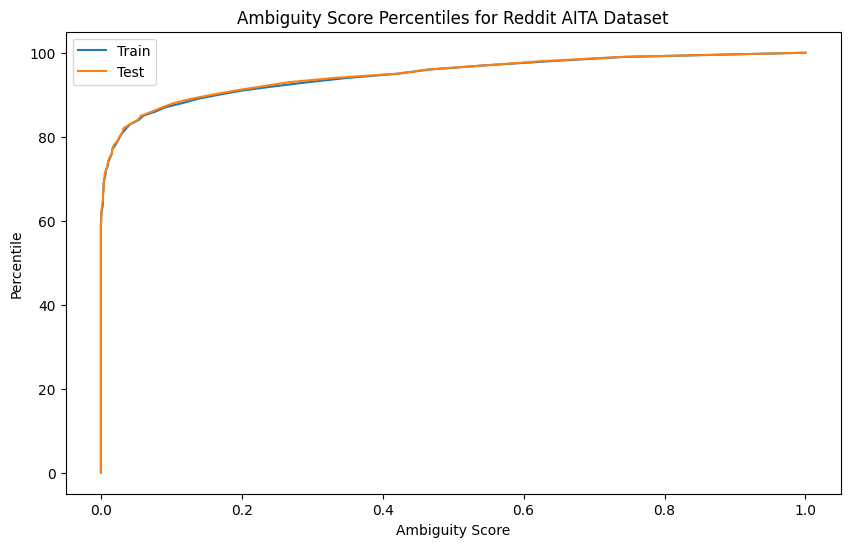

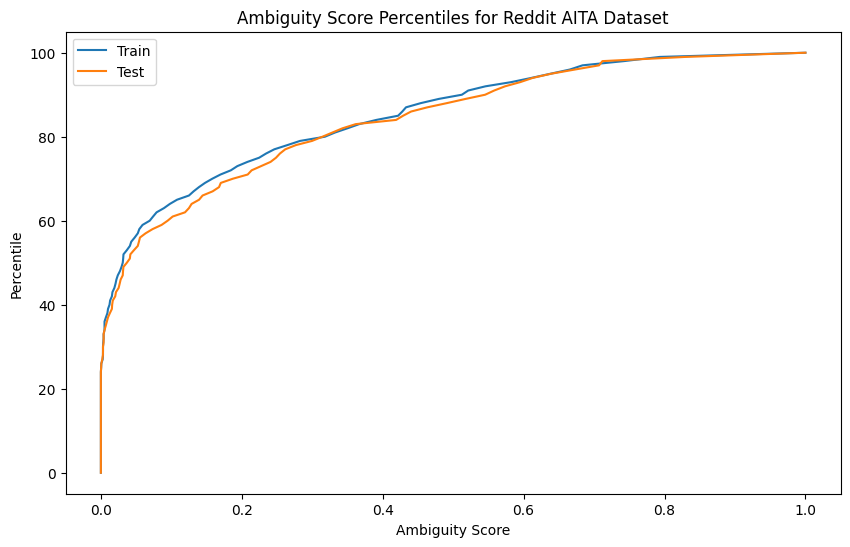

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Compute percentiles for 'train' and test datasets
train_percentiles = np.percentile(ambiguity_scores['train'], np.arange(0, 101, 1))
test_percentiles = np.percentile(ambiguity_scores['test'], np.arange(0, 101, 1))
combined_percentile_data = pd.DataFrame({
    "Percentile": np.arange(0, 101, 1),
    "Train Ambiguity Score": train_percentiles,
    "Test Ambiguity Score": test_percentiles
})

# Save the combined DataFrame to a CSV file
combined_percentile_data.to_csv("analysis_results/main_dataset/Decision_Ambiguity_Analysis/ambiguity_score_percentiles.csv", index=False)

# Plotting
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
plt.plot(train_percentiles, np.arange(0, 101, 1), label='Train')
plt.plot(test_percentiles, np.arange(0, 101, 1), label='Test')
plt.xlabel("Ambiguity Score")
plt.ylabel("Percentile")
plt.title("Ambiguity Score Percentiles for Reddit AITA Dataset")
plt.legend()
plt.savefig("analysis_results/main_dataset/Decision_Ambiguity_Analysis/ambiguity_score_percentiles.png")
plt.show()


# Compute percentiles for 'train' and test datasets
train_percentiles = np.percentile(samples_2500_ambiguity_scores['train'], np.arange(0, 101, 1))
test_percentiles = np.percentile(samples_2500_ambiguity_scores['test'], np.arange(0, 101, 1))
combined_percentile_data = pd.DataFrame({
    "Percentile": np.arange(0, 101, 1),
    "Train Ambiguity Score": train_percentiles,
    "Test Ambiguity Score": test_percentiles
})

# Save the combined DataFrame to a CSV file
combined_percentile_data.to_csv("analysis_results/2500_samples_dataset/Decision_Ambiguity_Analysis/ambiguity_score_percentiles.csv", index=False)

# Plotting
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
plt.plot(train_percentiles, np.arange(0, 101, 1), label='Train')
plt.plot(test_percentiles, np.arange(0, 101, 1), label='Test')
plt.xlabel("Ambiguity Score")
plt.ylabel("Percentile")
plt.title("Ambiguity Score Percentiles for Reddit AITA Dataset")
plt.legend()
plt.savefig("analysis_results/2500_samples_dataset/Decision_Ambiguity_Analysis/ambiguity_score_percentiles.png")
plt.show()

In [18]:

# Filter the dataset to include only samples with an ambiguity score of 0
zero_ambiguity_dataset = dataset.filter(lambda x: x['ambiguity_score'] == 0)
samples_2500_zero_ambiguity_dataset = samples_2500_dataset.filter(lambda x: x['ambiguity_score'] == 0)

Filter:   0%|          | 0/58438 [00:00<?, ? examples/s]

Filter:   0%|          | 0/14610 [00:00<?, ? examples/s]

Filter:   0%|          | 0/2000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/500 [00:00<?, ? examples/s]

In [20]:
import json

# Get counts for each dataset split
zero_ambiguity_count = len(zero_ambiguity_dataset['train']) + len(zero_ambiguity_dataset['test'])

# Calculate percentages
total_count= len(dataset['train']) + len(dataset['test'])
zero_ambiguity_percentage = round((zero_ambiguity_count / total_count) * 100, 3)

# Store results in dataframe and save to output CSV
zero_ambiguity_results = {
    'Number of Samples with Zero Ambiguity': [zero_ambiguity_count],
    'Percentage of Samples with Zero Ambiguity': [zero_ambiguity_percentage]
}

output_file = "analysis_results/main_dataset/Decision_Ambiguity_Analysis/zero_ambiguity_samples_results.json"

with open(output_file, 'w') as file:
    json.dump(zero_ambiguity_results, file, indent=4)


# Get counts for each dataset split
zero_ambiguity_count = len(samples_2500_zero_ambiguity_dataset['train']) + len(samples_2500_zero_ambiguity_dataset['test'])

# Calculate percentages
total_count= len(dataset['train']) + len(dataset['test'])
zero_ambiguity_percentage = round((zero_ambiguity_count / total_count) * 100, 3)

# Store results in dataframe and save to output CSV
zero_ambiguity_results = {
    'Number of Samples with Zero Ambiguity': [zero_ambiguity_count],
    'Percentage of Samples with Zero Ambiguity': [zero_ambiguity_percentage]
}

output_file = "analysis_results/2500_samples_dataset/Decision_Ambiguity_Analysis/zero_ambiguity_samples_results.json"

with open(output_file, 'w') as file:
    json.dump(zero_ambiguity_results, file, indent=4)

## Comment Agreement Analysis
- Holistic: Krippendorff's Alpha
  - Key aspects
    - "Krippendorff's alpha coefficient,[1] named after academic Klaus Krippendorff, is a statistical measure of the agreement achieved when coding a set of units of analysis. Since the 1970s, alpha has been used in content analysis where textual units are categorized by trained readers, in counseling and survey research where experts code open-ended interview data into analyzable terms, in psychological testing where alternative tests of the same phenomena need to be compared, or in observational studies where unstructured happenings are recorded for subsequent analysis."
    - "Krippendorff's alpha generalizes several known statistics, often called measures of inter-coder agreement, inter-rater reliability, reliability of coding given sets of units (as distinct from unitizing) but it also distinguishes itself from statistics that are called reliability coefficients but are unsuitable to the particulars of coding data generated for subsequent analysis."
    - "Krippendorff's alpha is applicable to any number of coders, each assigning one value to one unit of analysis, to incomplete (missing) data, to any number of values available for coding a variable, to binary, nominal, ordinal, interval, ratio, polar, and circular metrics (note that this is not a metric in the mathematical sense, but often the square of a mathematical metric, see levels of measurement), and it adjusts itself to small sample sizes of the reliability data. The virtue of a single coefficient with these variations is that computed reliabilities are comparable across any numbers of coders, values, different metrics, and unequal sample sizes.
  - [Wiki](https://en.wikipedia.org/wiki/Krippendorff%27s_alpha)
  - [Lecture by Krippendorff on Calculation](https://www.asc.upenn.edu/sites/default/files/2021-03/Computing%20Krippendorff%27s%20Alpha-Reliability.pdf)
  - [Article Explanation](https://www.surgehq.ai/blog/inter-rater-reliability-metrics-an-introduction-to-krippendorffs-alpha)
    - Ranges from -1 to 1, with -1 being complete disagreement, 0 being random choice, and 1 being complete agreement
    - 0.8 indicates significant agreement.

- Pairwise: Cohen's Kappa
  - [Wiki](https://en.wikipedia.org/wiki/Cohen%27s_kappa)
  - [Article Explanation](https://towardsdatascience.com/multi-class-metrics-made-simple-the-kappa-score-aka-cohens-kappa-coefficient-bdea137af09c)

In [22]:
import numpy as np
import krippendorff
from sklearn.metrics import cohen_kappa_score
from itertools import combinations

def get_encoded_classifications(dataset):
    """
    Encodes AITA classifications into numeric values, retaining None values.

    Parameters:
    dataset (list of dictionaries): A huggingface dataset

    Returns:
    list[list]: Lists of numeric classifications, with None where input was None
    """

    # Mapping of AITA classifications to numeric values
    classification_values = {'YTA': 1, 'ESH': 2,
                             'INFO': 3, 'NAH': 4,
                             'NTA': 5}

    # Initialize a list of lists, one for each of the top 10 comments
    top_comments = [[] for _ in range(10)]

    # Iterate over each sample in the dataset
    for sample in dataset:
        # Iterate over the top 10 comments
        for i in range(10):
            key = f'top_comment_{i+1}_classification'
            # Append the classification to the corresponding list
            top_comments[i].append(sample.get(key, None))

    # Convert classifications to their numeric representations, keeping None as is
    top_comments_encoded = []
    for i in range(len(top_comments)):
        encoded_comment = [classification_values.get(c, None) for c in top_comments[i]]
        top_comments_encoded.append(encoded_comment)
    return top_comments_encoded


def calculate_krippendorffs_alpha(dataset):
  """
  Calculates Krippendorff's alpha for a given dataset.

  Parameters:
  dataset (list of dictionaries): A huggingface dataset.

  Returns:
  float: Krippendorff's alpha score.
  """

  # Encode top comment classifications
  top_comments_encoded = get_encoded_classifications(dataset)

  # Calculate and return krippendorff's alpha
  data = np.array([[np.nan if x is None else x for x in sublist] for sublist in top_comments_encoded], dtype=float)
  return krippendorff.alpha(data)


def calculate_cohen_kappa(dataset):
  """
  Calculates Cohen's Kappa score for a given dataset.

  Parameters:
  dataset (list of dictionaries): A huggingface dataset.

  Returns:
  dict: A dictionary of Cohen's Kappa scores for each pair of top comments.
  """

  # encode top comment classifications
  top_comments_encoded = get_encoded_classifications(dataset)

  scores = {}
  for list1, list2 in combinations(top_comments_encoded, 2):
      filtered_list1 = []
      filtered_list2 = []
      for true, pred in zip(list1, list2):
          if true is not None and pred is not None:
              filtered_list1.append(true)
              filtered_list2.append(pred)
      score = cohen_kappa_score(filtered_list1, filtered_list2)
      index1 = top_comments_encoded.index(list1)
      index2 = top_comments_encoded.index(list2)
      key = (f"top_comment_{index1 + 1}", f"top_comment_{index2 + 1}")
      scores[key] = score
  return scores


def save_cohen_kappa_scores(cohen_kappa_scores, output_file):
  """
  Saves Cohen's Kappa scores to a CSV file.

  Parameters:
  cohen_kappa_scores (dict): A dictionary of Cohen's Kappa scores.
  output_file (str): The path to the output CSV file.
  """

  # create a list of column and row names
  comments = [f"top_comment_{i}" for i in range(1, 11)]

  # create an empty dataframe and fill with scores
  df = pd.DataFrame(index=comments, columns=comments)
  for (comment1, comment2), score in cohen_kappa_scores.items():
      df.at[comment1, comment2] = round(score, 3)

  # set the lower triangle to NaN, including the diagonal
  for i in range(len(df)):
      for j in range(i + 1):
          df.iat[i, j] = np.nan

  # save the dataframe
  df.to_csv(output_file, index=True)

In [23]:
import json

# Calculate and save Krippendorff's alphas for both train and test datasets
krippendorffs_alpha = {
    'train': calculate_krippendorffs_alpha(dataset['train']),
    'test': calculate_krippendorffs_alpha(dataset['test'])
}
output_file_alpha = "analysis_results/main_dataset/Comment_Agreement_Analysis/krippendorffs_alpha.json"
with open(output_file_alpha, "w") as f:
    json.dump(krippendorffs_alpha, f)

# Calculate and save Cohen's Kappa scores for both train and test datasets
cohen_kappa_scores = {
    'train': {str(key): value for key, value in calculate_cohen_kappa(dataset['train']).items()},
    'test': {str(key): value for key, value in calculate_cohen_kappa(dataset['test']).items()}
}
output_file_kappa = "analysis_results/main_dataset/Comment_Agreement_Analysis/cohen_kappa_scores.json"
with open(output_file_kappa, "w") as f:
    json.dump(cohen_kappa_scores, f)


# Calculate and save Krippendorff's alphas for both train and test datasets
krippendorffs_alpha = {
    'train': calculate_krippendorffs_alpha(samples_2500_dataset['train']),
    'test': calculate_krippendorffs_alpha(samples_2500_dataset['test'])
}
output_file_alpha = "analysis_results/2500_samples_dataset/Comment_Agreement_Analysis/krippendorffs_alpha.json"
with open(output_file_alpha, "w") as f:
    json.dump(krippendorffs_alpha, f)

# Calculate and save Cohen's Kappa scores for both train and test datasets
cohen_kappa_scores = {
    'train': {str(key): value for key, value in calculate_cohen_kappa(samples_2500_dataset['train']).items()},
    'test': {str(key): value for key, value in calculate_cohen_kappa(samples_2500_dataset['test']).items()}
}
output_file_kappa = "analysis_results/2500_samples_dataset/Comment_Agreement_Analysis/cohen_kappa_scores.json"
with open(output_file_kappa, "w") as f:
    json.dump(cohen_kappa_scores, f)